# Project: Image Classification with Ensemble Methods

## Problem

### The Problem
In this project, I will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. I will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data.

The goal with this implementation is to construct a model that accurately predicts whether an individual makes more than 50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features.

Note that the last column from this dataset, `income`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

### Source of Data
The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

## EDA

### Load Train Data
Train data is in the file `census.csv`

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time

# Import supplementary visualization code visuals.py
# import visuals as vs

# Pretty display for notebooks
%matplotlib inline

data = pd.read_csv('data/census.csv')

### Split train and test set
Split before EDA to avoid data leakage

In [3]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

### Look at the Data Structure

In [4]:
train_set.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
7963,32,Private,Bachelors,13.0,Never-married,Exec-managerial,Not-in-family,White,Female,0.0,0.0,40.0,United-States,<=50K
26402,45,Private,Assoc-acdm,12.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,66.0,Yugoslavia,<=50K
31411,45,Self-emp-not-inc,11th,7.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
13367,39,Self-emp-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,70.0,United-States,<=50K
38742,51,State-gov,HS-grad,9.0,Divorced,Adm-clerical,Not-in-family,White,Female,0.0,0.0,38.0,United-States,<=50K


In [5]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36177 entries, 7963 to 15795
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              36177 non-null  int64  
 1   workclass        36177 non-null  object 
 2   education_level  36177 non-null  object 
 3   education-num    36177 non-null  float64
 4   marital-status   36177 non-null  object 
 5   occupation       36177 non-null  object 
 6   relationship     36177 non-null  object 
 7   race             36177 non-null  object 
 8   sex              36177 non-null  object 
 9   capital-gain     36177 non-null  float64
 10  capital-loss     36177 non-null  float64
 11  hours-per-week   36177 non-null  float64
 12  native-country   36177 non-null  object 
 13  income           36177 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 4.1+ MB


look at values in categorical columns

In [6]:
# get categorical columns of the data
cat_cols = train_set.select_dtypes(include='object').columns.tolist()

In [7]:
# show value counts for all categorical columns
pd.DataFrame(data[cat_cols]
    .melt(var_name='column', value_name='value')
    .value_counts()).sort_values(by=['column'])

count
column          value                   
education_level  12th                577
                 Preschool            72
                 Assoc-voc          1959
                 Masters            2514
                 10th               1223
...                                  ...
workclass        Without-pay          21
                 Private           33307
                 Self-emp-not-inc   3796
                 Federal-gov        1406
                 Local-gov          3100

[100 rows x 1 columns]

In [8]:
train_set.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,36177.000000,36177.000000,36177.000000,36177.000000,36177.000000
mean,38.558283,10.117091,1089.335766,87.182962,40.952318
std,13.232872,2.554611,7519.871123,401.695413,11.988401
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


look at distribution of numerical columns. The histogram shows that:
- some features are skewed, so transformation is required.
- features are on different scales, so scaling is required

C:\Users\ymw13\AppData\Local\Temp\ipykernel_9340\920049775.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_set.hist(bins=50, ax=ax)


Text(0.5, 0.98, 'Histogram of numerical columns')

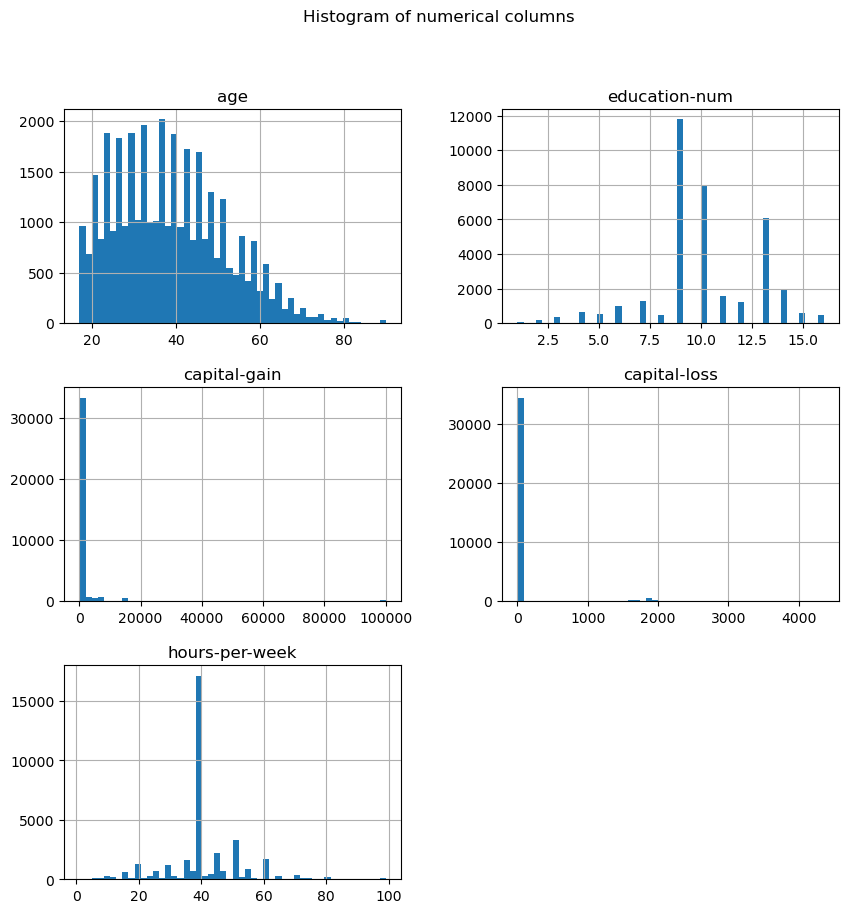

In [9]:
# plot histogram of numerical columns

import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 10))
train_set.hist(bins=50, ax=ax)
f.suptitle('Histogram of numerical columns')

### Investigate Feature Columns

How many values in column `capital-gain` and `capital-loss` is zero ?

In [10]:
train_set['capital-gain'].groupby(data['capital-gain'] == 0).count()

capital-gain
False     2995
True     33182
Name: capital-gain, dtype: int64

In [11]:
train_set['capital-loss'].groupby(data['capital-loss'] == 0).count()

capital-loss
False     1689
True     34488
Name: capital-loss, dtype: int64

Since there are too many zeros in column `capital-gain` and `capital-loss`, I may do some transformations to these columns.

### Investigate Response Variable

In [12]:
# Total number of records
n_records = train_set.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = train_set.income.value_counts()['>50K']

# Number of records where individual's income is at most $50,000
n_at_most_50k = train_set.income.value_counts()['<=50K']

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k / (n_greater_50k + n_at_most_50k)

# Print the results
print(f"Total number of records: {n_records}")
print(f"Individuals making more than $50,000: {n_greater_50k}")
print(f"Individuals making at most $50,000: {n_at_most_50k}")
print(f"Percentage of individuals making more than $50,000: {greater_percent}")

Total number of records: 36177
Individuals making more than $50,000: 8908
Individuals making at most $50,000: 27269
Percentage of individuals making more than $50,000: 0.24623379495259418


We noticed that the two classes are imbalanced. As a result, we should
- not use accuracy as the metrics
- apply stratified sampling in cross-validation

### Investigate test set
Check if test set has any NA values

In [13]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9045 entries, 20084 to 10059
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              9045 non-null   int64  
 1   workclass        9045 non-null   object 
 2   education_level  9045 non-null   object 
 3   education-num    9045 non-null   float64
 4   marital-status   9045 non-null   object 
 5   occupation       9045 non-null   object 
 6   relationship     9045 non-null   object 
 7   race             9045 non-null   object 
 8   sex              9045 non-null   object 
 9   capital-gain     9045 non-null   float64
 10  capital-loss     9045 non-null   float64
 11  hours-per-week   9045 non-null   float64
 12  native-country   9045 non-null   object 
 13  income           9045 non-null   object 
dtypes: float64(4), int64(1), object(9)
memory usage: 1.0+ MB


In [14]:
test_set.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
20084,28,Private,Masters,14.0,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,45.0,France,>50K
20027,60,Private,9th,5.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,45.0,United-States,<=50K
39505,43,Private,Some-college,10.0,Never-married,Adm-clerical,Not-in-family,White,Male,0.0,1669.0,45.0,United-States,<=50K
39534,35,State-gov,HS-grad,9.0,Married-civ-spouse,Other-service,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K
12586,36,Private,Some-college,10.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States,>50K


### Spliting Features and Labels

In [37]:
# Split the data into features and target label
train_X_raw = train_set.drop('income', axis = 1)
train_y_raw = train_set['income']

### Split Categorical and Numerical Features

First find numerical and categorical columns names

In [40]:
# numerical variables in features
X_num_name = train_X_raw.select_dtypes(include=np.number).columns.values.tolist()

# categorical variables in features
X_cat_name = train_X_raw.select_dtypes(include=object).columns.values.tolist()

then split the train set by dtypes

In [42]:
train_X_num_raw = train_set[X_num_name]
train_X_cat_raw = train_set[X_cat_name]

## Feature Engineering and selection

### Transform Manually

#### Log Transformation for Skewed Features
Since features '`capital-gain'` and `'capital-loss'` apparently skewed, log transformation should be applied.
Let's first review the distributions of these two features

Text(0.5, 0.98, 'Distributions of Skewed Features')

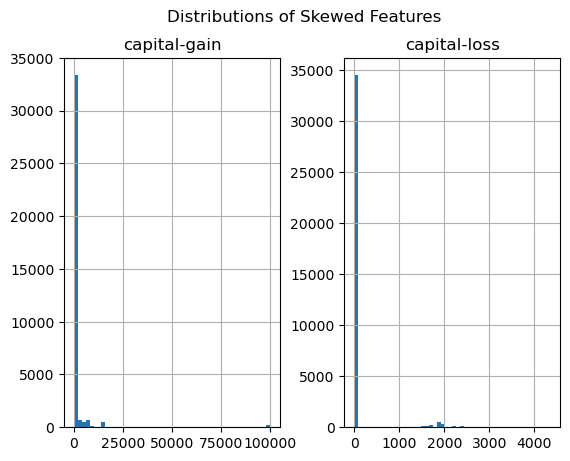

In [17]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 2)
train_X_num_raw[['capital-gain', 'capital-loss']].hist(ax=ax, bins=50)

f.suptitle('Distributions of Skewed Features')

then create a custom transformer to apply log transformation to train set

In [43]:
# build a custom transformer
from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log1p, feature_names_out='one-to-one')

# make a copy of data set
train_X_num_transformed = train_X_num_raw.copy()

# apply the transformer
train_X_num_transformed[['capital-gain', 'capital-loss']] = log_transformer.fit_transform(train_X_num_transformed[['capital-gain', 'capital-loss']])

Look at the distributions after log transformation. Although there are many 0 values, the shape looks a bit more 'Bell-curved'.

Text(0.5, 0.98, 'Distributions of Skewed Features After Log Transformation')

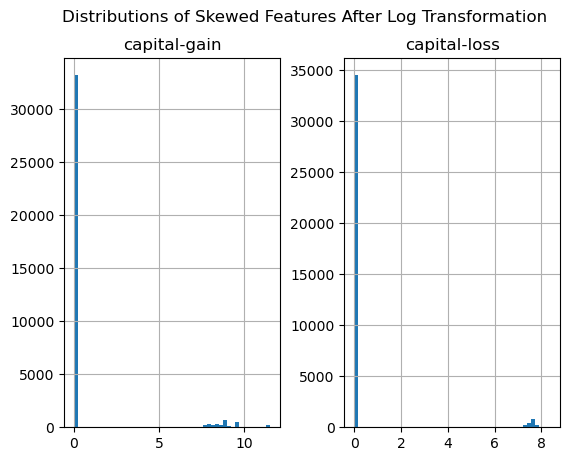

In [19]:
f, ax = plt.subplots(1, 2)
train_X_num_transformed[['capital-gain', 'capital-loss']].hist(ax=ax, bins=50)
f.suptitle('Distributions of Skewed Features After Log Transformation')

#### Feature Standardization

For better performance, standardization will be applied to numerical columns

In [20]:
train_X_num_transformed = train_X_num_raw

train_X_num_transformed.columns.values.tolist()

['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [21]:
# Initialize a scaler, then apply it to the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # default=(0, 1)

# transform
train_X_num_transformed = scaler.fit_transform(train_X_num_transformed)
train_X_num_transformed = pd.DataFrame(train_X_num_transformed, columns=X_num_name)

In [22]:
train_X_num_transformed

,age,education-num,capital-gain,capital-loss,hours-per-week
0,-0.495612,1.128527,-0.144863,-0.21704,-0.079438
1,0.486803,0.737073,-0.144863,-0.21704,2.089355
2,0.486803,-1.220199,-0.144863,-0.21704,0.754713
3,0.033381,-0.437290,-0.144863,-0.21704,2.423016
4,0.940226,-0.437290,-0.144863,-0.21704,-0.246268
...,...,...,...,...,...
36172,-0.949035,-0.045836,-0.144863,-0.21704,-0.079438
36173,-1.100176,1.128527,-0.144863,-0.21704,0.754713
36174,-0.571183,-0.045836,-0.144863,-0.21704,-0.079438
36175,-0.117760,-0.437290,-0.144863,-0.21704,4.842054


Look at the distributions after standardization.

Text(0.5, 0.98, 'Distributions of Numerical Features after standardization')

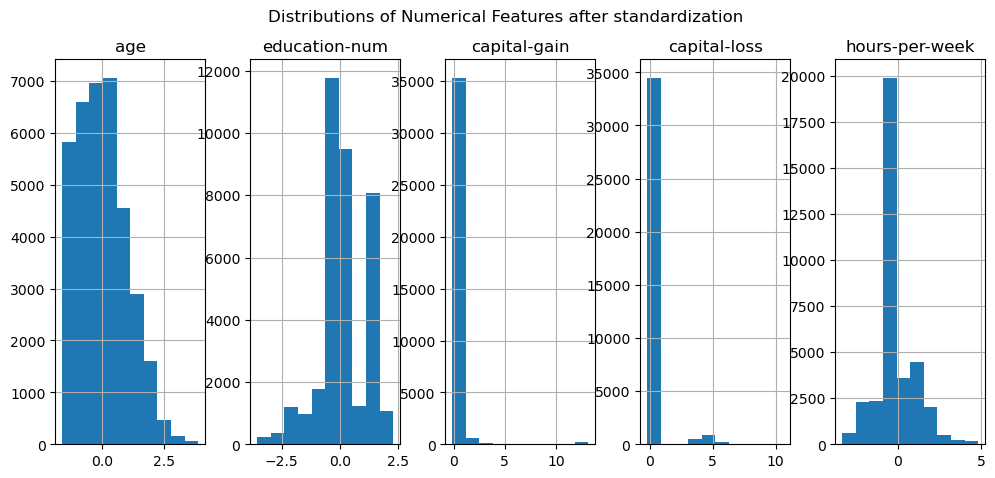

In [23]:
# plot the distribution after transformation
f, ax = plt.subplots(1, len(X_num_name), figsize=(12, 5))
train_X_num_transformed.hist(bins=10, ax=ax)
f.suptitle('Distributions of Numerical Features after standardization')

#### Encoding for Categorical Columns

In [24]:
# initialize encoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
encoder1 = OneHotEncoder()
encoder2 = OrdinalEncoder(categories=[['<=50K', '>50K']])


# apply encoder to categorical features
train_features_cat_transformed = encoder1.fit_transform(train_X_cat_raw)

# apply encoder to labels
train_labels_transformed = encoder2.fit_transform(train_y_raw.to_numpy()[:, np.newaxis])

# view label categories
encoder2.categories_

[array(['<=50K', '>50K'], dtype=object)]

In [25]:
# covert sparse matrix to Dataframe

# write a function to convert
def sparse_to_dataframe(csr_matrix, encoder):
    """
    convert scipy sparse matrix(result of one-hot encoding) to pandas dataframe
    :param csr_matrix: sparse matrix
    :param encoder: one-hot encoder
    :return: dataframe
    """
    df = pd.DataFrame(csr_matrix.toarray(), columns=encoder.get_feature_names_out())
    return df

# apply the function
train_features_cat_transformed = sparse_to_dataframe(train_features_cat_transformed, encoder1)

In [26]:
# combine categorical and numerical features
train_features_transformed = pd.concat([train_X_num_transformed, train_features_cat_transformed], axis=1)
train_features_transformed

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,-0.495612,1.128527,-0.144863,-0.21704,-0.079438,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.486803,0.737073,-0.144863,-0.21704,2.089355,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.486803,-1.220199,-0.144863,-0.21704,0.754713,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.033381,-0.437290,-0.144863,-0.21704,2.423016,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.940226,-0.437290,-0.144863,-0.21704,-0.246268,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36172,-0.949035,-0.045836,-0.144863,-0.21704,-0.079438,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
36173,-1.100176,1.128527,-0.144863,-0.21704,0.754713,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
36174,-0.571183,-0.045836,-0.144863,-0.21704,-0.079438,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
36175,-0.117760,-0.437290,-0.144863,-0.21704,4.842054,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Transform by Pipelines
Reformat all above steps into transformation pipline, and apply the pipeline to train and test data

In [156]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer


# pipeline which first apply log transformation and then standard scaling, applied to 'capital-gain' and 'capital-loss'
pipeline_log_scale = Pipeline([('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
                               ('scaler', StandardScaler())])

# pipeline for all features
pipeline_X = ColumnTransformer(
    transformers=[
        ('log_scale', pipeline_log_scale, make_column_selector(pattern='capital-')),
        ('standardizer', StandardScaler(), ['age', 'education-num', 'hours-per-week']),
        ('one-hot', OneHotEncoder(handle_unknown="infrequent_if_exist", sparse_output=False), make_column_selector(dtype_include=object)),
    ])

# pipeline for X, including to_dense
# pipeline_X = Pipeline(
#     steps=[
#         # pipeline for all features
#         ('trans', X_transform),
#
#         # convert sparse output to dense matrix
#         ("to_dense", FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
#     ]
# )

# pipeline for labels
pipeline_y = Pipeline(
    steps=[
        ('ordinal-encode', OrdinalEncoder(categories=[['<=50K', '>50K']]))
    ])

In [157]:
# apply pipeline to train sets
train_X_pipe = pipeline_X.fit_transform(train_X_raw)
train_y_pipe = pipeline_y.fit_transform(train_y_raw.to_numpy()[:, np.newaxis])

# apply same transform to test sets
test_X_pipe = pipeline_X.transform(test_set.drop('income', axis=1))
test_y_pipe = pipeline_y.transform(test_set['income'].to_numpy()[:, np.newaxis])

In [158]:
# check if output is sparse
import scipy
print(isinstance(train_X_pipe, scipy.sparse.csc_matrix))
print(isinstance(train_y_pipe, scipy.sparse.csc_matrix))

False
False


In [159]:
train_y_pipe

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]])

In [161]:
# view transformed X(features)
pd.DataFrame(train_X_pipe, columns=pipeline_X.get_feature_names_out())

,log_scale__capital-gain,log_scale__capital-loss,standardizer__age,standardizer__education-num,standardizer__hours-per-week,one-hot__workclass_ Federal-gov,one-hot__workclass_ Local-gov,one-hot__workclass_ Private,one-hot__workclass_ Self-emp-inc,one-hot__workclass_ Self-emp-not-inc,...,one-hot__native-country_ Portugal,one-hot__native-country_ Puerto-Rico,one-hot__native-country_ Scotland,one-hot__native-country_ South,one-hot__native-country_ Taiwan,one-hot__native-country_ Thailand,one-hot__native-country_ Trinadad&Tobago,one-hot__native-country_ United-States,one-hot__native-country_ Vietnam,one-hot__native-country_ Yugoslavia
0,-0.298294,-0.221171,-0.495612,1.128527,-0.079438,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.298294,-0.221171,0.486803,0.737073,2.089355,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.298294,-0.221171,0.486803,-1.220199,0.754713,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.298294,-0.221171,0.033381,-0.437290,2.423016,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.298294,-0.221171,0.940226,-0.437290,-0.246268,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36172,-0.298294,-0.221171,-0.949035,-0.045836,-0.079438,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
36173,-0.298294,-0.221171,-1.100176,1.128527,0.754713,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
36174,-0.298294,-0.221171,-0.571183,-0.045836,-0.079438,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
36175,-0.298294,-0.221171,-0.117760,-0.437290,4.842054,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [162]:
# view names of features
pipeline_X.get_feature_names_out()

array(['log_scale__capital-gain', 'log_scale__capital-loss',
       'standardizer__age', 'standardizer__education-num',
       'standardizer__hours-per-week', 'one-hot__workclass_ Federal-gov',
       'one-hot__workclass_ Local-gov', 'one-hot__workclass_ Private',
       'one-hot__workclass_ Self-emp-inc',
       'one-hot__workclass_ Self-emp-not-inc',
       'one-hot__workclass_ State-gov', 'one-hot__workclass_ Without-pay',
       'one-hot__education_level_ 10th', 'one-hot__education_level_ 11th',
       'one-hot__education_level_ 12th',
       'one-hot__education_level_ 1st-4th',
       'one-hot__education_level_ 5th-6th',
       'one-hot__education_level_ 7th-8th',
       'one-hot__education_level_ 9th',
       'one-hot__education_level_ Assoc-acdm',
       'one-hot__education_level_ Assoc-voc',
       'one-hot__education_level_ Bachelors',
       'one-hot__education_level_ Doctorate',
       'one-hot__education_level_ HS-grad',
       'one-hot__education_level_ Masters',
       'o

### Feature Engineering
Perform auto feature engineering with [featurewiz](https://github.com/AutoViML/featurewiz#install)

In [66]:
train_set

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
7963,32,Private,Bachelors,13.0,Never-married,Exec-managerial,Not-in-family,White,Female,0.0,0.0,40.0,United-States,<=50K
26402,45,Private,Assoc-acdm,12.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,66.0,Yugoslavia,<=50K
31411,45,Self-emp-not-inc,11th,7.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
13367,39,Self-emp-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,70.0,United-States,<=50K
38742,51,State-gov,HS-grad,9.0,Divorced,Adm-clerical,Not-in-family,White,Female,0.0,0.0,38.0,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,26,Private,Some-college,10.0,Divorced,Adm-clerical,Not-in-family,White,Female,0.0,0.0,40.0,United-States,<=50K
44732,24,Private,Bachelors,13.0,Never-married,Sales,Other-relative,Black,Male,0.0,0.0,50.0,United-States,<=50K
38158,31,Private,Some-college,10.0,Never-married,Adm-clerical,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
860,37,Private,HS-grad,9.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,99.0,United-States,>50K


In [68]:
import featurewiz as fwiz

outputs = fwiz.featurewiz(dataname=train_set, target='income', test_data='', corr_limit=0.70, verbose=2, sep=',', header=0, category_encoders='Onehot', dask_xgboost_flag=False, nrows=None, skip_sulov=False, skip_xgboost=False)


############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
#### Single_Label Binary_Classification problem ####
    Loaded train data. Shape = (36177, 14)
    Some column names had special characters which were removed...
#### Single_Label Binary_Classification problem ####
No test data filename given...
Classifying features using a random sample of 10000 rows from dataset...
#### Single_Label Binary_Classification problem ####
    loading a random sample of 10000 rows into pandas for EDA
########################################

AttributeError: 'DataFrame' object has no attribute 'append'

In [69]:
train_y_auto = outputs[1].income
train_X_auto = outputs[1].drop('income', axis=1)
feature_name_autp = outputs[0]

NameError: name 'outputs' is not defined

In [59]:
train_X_auto

,age,educationnum,capitalgain,capitalloss
7963,32,13.0,0.0,0.0
26402,45,12.0,0.0,0.0
31411,45,7.0,0.0,0.0
13367,39,9.0,0.0,0.0
38742,51,9.0,0.0,0.0
...,...,...,...,...
11284,26,10.0,0.0,0.0
44732,24,13.0,0.0,0.0
38158,31,10.0,0.0,0.0
860,37,9.0,0.0,0.0


## Select and Train Models

### Select Metrics
Due to class imbalance('1' accounts for 24.7%, '0' for 75.3%), we cannot choose accuracy as the metrics. According to [Best techniques and metrics for Imbalanced Dataset](https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-datasetInstead), since false negatives are more costly(we try to find out as much individuals who earn more than 50k as possible), we should use F-2 score as metrics. In such condition, we put more emphasizes on recall.

However, since the [Kaggle competiton](https://www.kaggle.com/competitions/udacity-mlcharity-competition/overview) used AUC as the metrics, we will use AUC for model selection and parameter tunning.

###  Models for classification
The following are some supervised learning models to be chosen from:
- linearSVC
- SVC with radial kernel
- Random Forest
- Ada boosting
- Gradient Boosting
- XG Boosting

### Initial Evaluation with Cross-Validation
This part evaluate serval models on the training set with cross-validation, and select a few promising models for parameter tuning.

In [24]:
# function to print results
def display_scores(scores):
    print(f'Mean: {scores.mean():.3f}')
    print(f'Standard deviation: {scores.std():.3f}')

In [26]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit

# initialize
clf_svc = LinearSVC(dual=False)
clf_rbf = SVC()
clf_rf = RandomForestClassifier()
clf_ada = AdaBoostClassifier()
clf_gb = GradientBoostingClassifier()
clf_xgb = XGBClassifier()

In [178]:
# a dict for score of each model
model_score_ini_score = {}
# a dict for run time of each model
model_score_ini_time = {}
# a dict for fitted estimator of each model
model_ini = {}

# train and evaluate
for model in [clf_svc, clf_rbf, clf_ada, clf_gb, clf_xgb]:

    # get names of each model
    model_name = model.__class__.__name__

    # create pipeline containing data transformation and model
    pipeline_cv = Pipeline(steps=[

        # transformation pipeline for features
        ("trans_X", pipeline_X),

         # model for predict
        ("model", model)])

    # cv
    model_scores = cross_validate(pipeline_cv,
                                  train_X_raw,
                                  np.ravel(train_y_pipe),
                                  scoring=make_scorer(roc_auc_score),
                                  return_estimator=True,
                                  cv=StratifiedShuffleSplit(test_size=0.25),
                                  n_jobs=-1)

    model_score_ini_score[model_name] = model_scores['test_score']
    model_score_ini_time[model_name] = model_scores['fit_time']
    model_ini[model_name] = model_scores['estimator']

    print(f'Test score for {model_name}:')
    display_scores(model_scores['test_score'])
    print(f'fit time for {model_name}:')
    display_scores(model_scores['fit_time'])
    print('\n')

Test score for LinearSVC:
Mean: 0.752
Standard deviation: 0.004
fit time for LinearSVC:
Mean: 0.554
Standard deviation: 0.070


Test score for SVC:
Mean: 0.760
Standard deviation: 0.004
fit time for SVC:
Mean: 75.971
Standard deviation: 0.355


Test score for AdaBoostClassifier:
Mean: 0.773
Standard deviation: 0.004
fit time for AdaBoostClassifier:
Mean: 4.147
Standard deviation: 0.091


Test score for GradientBoostingClassifier:
Mean: 0.773
Standard deviation: 0.004
fit time for GradientBoostingClassifier:
Mean: 15.012
Standard deviation: 0.153


Test score for XGBClassifier:
Mean: 0.797
Standard deviation: 0.005
fit time for XGBClassifier:
Mean: 0.755
Standard deviation: 0.031




In [179]:
# view mean of roc_auc_score
pd.DataFrame(model_score_ini_score).mean().sort_values(ascending=False)

XGBClassifier                 0.797398
GradientBoostingClassifier    0.772710
AdaBoostClassifier            0.772504
SVC                           0.760493
LinearSVC                     0.752010
dtype: float64

In [180]:
# view std of roc_auc_score
pd.DataFrame(model_score_ini_score).std().sort_values()

SVC                           0.003948
AdaBoostClassifier            0.003952
LinearSVC                     0.004064
GradientBoostingClassifier    0.004710
XGBClassifier                 0.005556
dtype: float64

### Plot Learning Curve
Learning curve can illustrate if the model is over-fitted.

Text(0.5, 0.98, 'Learning Curve for Models')

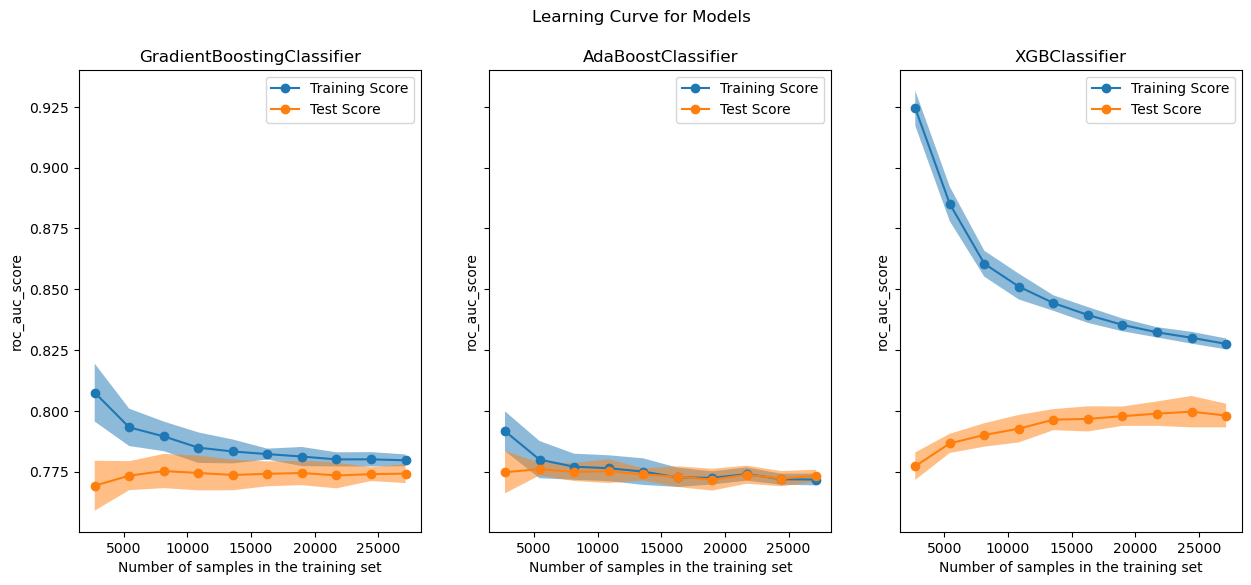

In [31]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6), sharey=True)

common_para = {
    'X': train_X_pipe,
    'y': np.ravel(train_y_pipe),
    'train_sizes': np.linspace(0.1, 1, 10),
    'n_jobs': 8,
    'line_kw': {'marker': 'o'},
    'score_name': 'roc_auc_score',
    'scoring': make_scorer(roc_auc_score),
    'cv': StratifiedShuffleSplit(test_size=0.25),
    'score_type': 'both'
}

for idx, estimator in enumerate([clf_gb, clf_ada, clf_xgb]):
    LearningCurveDisplay.from_estimator(estimator, **common_para, ax=ax[idx])
    handles, labels = ax[idx].get_legend_handles_labels()
    ax[idx].legend(handles[0:2], ['Training Score', 'Test Score'])
    ax[idx].set_title(f'{estimator.__class__.__name__}')

fig.suptitle(f'Learning Curve for Models')

The Learning Curve shows that:
- XG Boosting model has high variance and high accuracy.
- Gradient Boosting and Ada Boosting models have low variance and low bias.

### Conclusions
Considering all model's performance, XG Boost is the best model. The next part will find the best parameters for these models.

For other models' roc score, we can find that
    - Ada boosting have low bias and low variance.
    - Gradient boosting have low bias and relatively high variance.
    - Linear SVC has high bias while relatively low variance.
    - SVC(rbf kernel) has high bias while low variance.

For other models' fitting time, we can find that
    - SVC(rbf kernel) is the slowest model, and Linear SVC is the fastest.
    - XG Boost is the fastest model among all ensemble models, while Gradient Boost is the slowest.


## Fine-Tune Models

### Tuning XG Boosting Model
This part use grid search to find parameters to decrease the variance of XG Boosting model.

### Grid-Search
The following parameters will be tuned:
- `max_depth`: try lower values to reduce variance
- `min_child_weight`: try larger values to reduce variance
- `gamma`: try larger values to reduce variance

To avoid over-fiting, a pipeline combining data transformation and xgboost is used for grid search.
References on [sklearn doc](https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html)

In [133]:
from sklearn.model_selection import GridSearchCV

# use pipeline to avoid data leakage
pipe_trans_xgb = Pipeline(steps=[

    # transformation pipeline for features
    ("trans_X", pipeline_X),

    # model
    ("xgb", XGBClassifier())])

# first grid search for xgb
para_xgb = {'xgb__max_depth': np.arange(1, 6),
            'xgb__min_child_weight': np.arange(1, 8),
            #'xgb__gamma': np.linspace(0, 1, 4),
            }

# fit
gridsearch_xgb = GridSearchCV(pipe_trans_xgb,
                              param_grid=para_xgb,
                              scoring=make_scorer(roc_auc_score),
                              cv=StratifiedShuffleSplit(test_size=0.2),
                              verbose=2,
                              n_jobs=-1,
                              error_score=True)

gridsearch_xgb.fit(train_X_raw, train_y_pipe)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.2,
            train_size=None),
             error_score=True,
             estimator=Pipeline(steps=[('trans_X',
                                        ColumnTransformer(transformers=[('log_scale',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<ufunc 'log1p'>)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__max_depth': array([1, 2, 3, 4, 5]),
                         'xgb__min_child_weight': array([1, 2, 3, 4, 5, 6, 7])},
             scoring=make_scorer(roc_auc_score), verbose=2)

In [134]:
# view results
print(f'best parameter: {gridsearch_xgb.best_params_}')
print(f'best score: {gridsearch_xgb.best_score_}')

best parameter: {'xgb__max_depth': 5, 'xgb__min_child_weight': 2}
best score: 0.7988729428498406


In [124]:
# get the best xgboost model from grid search
xgb_grid_best = gridsearch_xgb.best_estimator_[1]
xgb_grid_best

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [125]:
# save model
from joblib import dump, load

dump(xgb_grid_best, 'model_saved/xgb_grid_best.joblib')

['model_saved/xgb_grid_best.joblib']

### Auto-search
Using Grid-search is impossible for large searching space due to limited computational power. Instead, use Optuna to perform bayes-optimization for searching best parameters.

In [130]:
import optuna

# define objective
def objective(trial):

    # define validation set for optuna
    train_X_opt, val_X_opt, train_y_opt, val_y_opt = train_test_split(train_X_raw, train_y_raw, test_size=0.25)
    
    # pre-process train data
    train_X_opt_pipe = pipeline_X.fit_transform(train_X_opt)
    train_y_opt_pipe = pipeline_y.fit_transform(train_y_opt.to_numpy()[:, np.newaxis])
    
    # pre-process validation data
    val_X_opt_pipe = pipeline_X.transform(val_X_opt)
    val_y_opt_pipe = pipeline_y.transform(val_y_opt.to_numpy()[:, np.newaxis])
    

    # search space
    para = {
       'reg_lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'reg_alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', np.arange(0.3, 1.1,0.1).tolist()),
        'subsample': trial.suggest_categorical('subsample', np.arange(0.4, 1.1, 0.1).tolist()),
        'learning_rate': trial.suggest_categorical('learing_rate', np.arange(0.01, 0.22, 0.02).tolist()),
        'n_estimators': trial.suggest_int('n_estimators', 10, 4000),
        'max_depth': trial.suggest_categorical('max_depth', np.arange(5, 21, 2).tolist()),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300)
    }

    # initialize xgb model
    model_opt = XGBClassifier(**para)

    # fit, validate, score
    model_opt.fit(train_X_opt_pipe, train_y_opt_pipe)
    pred_opt = model_opt.predict(val_X_opt_pipe)
    score_opt = roc_auc_score(val_y_opt_pipe, pred_opt)

    # return roc score
    return score_opt

# optimize parameter
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# print results
print('Number of finished trials:', len(study.trials))

[I 2023-11-25 11:28:50,118] A new study created in memory with name: no-name-ceeed362-c1e6-4fe2-9e63-ddef82a066a7
[I 2023-11-25 11:28:55,632] Trial 0 finished with value: 0.7782933126590897 and parameters: {'lambda': 6.976406660663322, 'alpha': 0.0019596063081272503, 'colsample_bytree': 1.0000000000000002, 'subsample': 0.7999999999999999, 'learing_rate': 0.03, 'n_estimators': 2702, 'max_depth': 17, 'min_child_weight': 102}. Best is trial 0 with value: 0.7782933126590897.
[I 2023-11-25 11:28:57,019] Trial 1 finished with value: 0.7670296103488043 and parameters: {'lambda': 0.041931492001786703, 'alpha': 0.08560421064141542, 'colsample_bytree': 0.6000000000000001, 'subsample': 0.6, 'learing_rate': 0.08999999999999998, 'n_estimators': 1140, 'max_depth': 5, 'min_child_weight': 124}. Best is trial 0 with value: 0.7782933126590897.
[I 2023-11-25 11:29:01,627] Trial 2 finished with value: 0.7722182490449274 and parameters: {'lambda': 9.636276893285354, 'alpha': 0.035458511287401316, 'colsampl

Number of finished trials: 50


In [138]:
# view reuslts
print('Best trial:', study.best_params)
print('Best value:', study.best_value)

Best trial: {'lambda': 0.04748718248896843, 'alpha': 0.0028071045402475957, 'colsample_bytree': 1.0000000000000002, 'subsample': 0.9999999999999999, 'learing_rate': 0.01, 'n_estimators': 2600, 'max_depth': 7, 'min_child_weight': 22}
Best value: 0.8034337091131851


In [136]:
# re-fit
xgb_opt_best = XGBClassifier(**study.best_params)
xgb_opt_best.fit(train_X_pipe, train_y_pipe)

D:\program_location\program_code\Anaconda\envs\torch\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:09:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "learing_rate" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=0.0028071045402475957, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0000000000000002, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.04748718248896843,
              learing_rate=0.01, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=22, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2600, ...)

In [177]:
# save model
from joblib import dump, load

dump(xgb_opt_best, 'model_saved/xgb_auto_best.joblib')

['model_saved/xgb_auto_best.joblib']

### Plot learning curve
Results show the model from grid search perform better.

Text(0.5, 0.98, 'XGB Learning Curve')

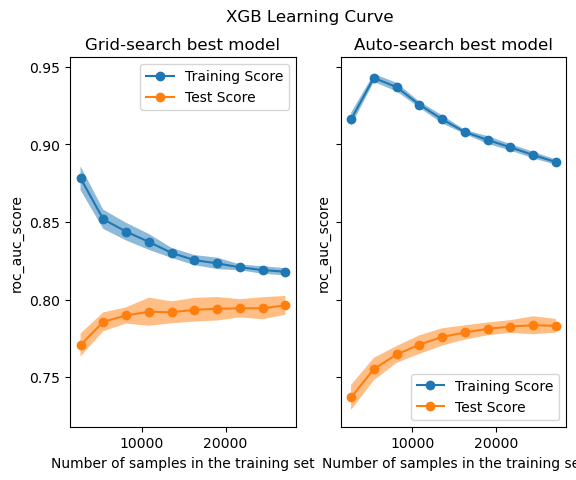

In [139]:
common_para = {
    'X': train_X_pipe,
    'y': np.ravel(train_y_pipe),
    'train_sizes': np.linspace(0.1, 1, 10),
    'n_jobs': -1,
    'line_kw': {'marker': 'o'},
    'score_name': 'roc_auc_score',
    'scoring': make_scorer(roc_auc_score),
    'cv': StratifiedShuffleSplit(test_size=0.25),
    'score_type': 'both'
}

# plot learning curve
fig, ax = plt.subplots(1, 2, sharex=True)
for idx, model in enumerate([xgb_grid_best, xgb_opt_best]):

    LearningCurveDisplay.from_estimator(model, **common_para, ax=ax[idx])
    handles, labels = ax[idx].get_legend_handles_labels()
    ax[idx].legend(handles[0:2], ['Training Score', 'Test Score'])

ax[0].set_title('Grid-search best model')
ax[1].set_title('Auto-search best model')

fig.suptitle(f'XGB Learning Curve')

## Make Predictions
make predictions on `test_census.csv` to submitted to Kaggle.


### Investigate dataset for prediction

In [140]:
# read file
predict_set_raw = pd.read_csv('data/test_census.csv', index_col=0)

In [141]:
predict_set_raw.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,21.0,Private,10th,6.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States
1,49.0,Private,Bachelors,13.0,Married-civ-spouse,Adm-clerical,Wife,White,Female,0.0,0.0,40.0,United-States
2,44.0,Self-emp-not-inc,Assoc-acdm,12.0,Married-civ-spouse,Other-service,Wife,White,Female,0.0,0.0,99.0,United-States
3,34.0,Private,Bachelors,13.0,Married-civ-spouse,Sales,Husband,White,Male,7298.0,0.0,46.0,United-States
4,24.0,Private,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States


In [142]:
predict_set_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45222 entries, 0 to 45221
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45205 non-null  float64
 1   workclass        45200 non-null  object 
 2   education_level  45202 non-null  object 
 3   education-num    45208 non-null  float64
 4   marital-status   45201 non-null  object 
 5   occupation       45200 non-null  object 
 6   relationship     45206 non-null  object 
 7   race             45203 non-null  object 
 8   sex              45203 non-null  object 
 9   capital-gain     45207 non-null  float64
 10  capital-loss     45205 non-null  float64
 11  hours-per-week   45209 non-null  float64
 12  native-country   45206 non-null  object 
dtypes: float64(5), object(8)
memory usage: 4.8+ MB


There are nan in the file `test_census.csv`, which is different from `census.csv`.

### Handling NA for ML

We will impute nan values, by median or mode of training data

In [144]:
from sklearn.impute import SimpleImputer

# transform pipeline for imputing values
pipeline_imputer = ColumnTransformer(
    transformers=[
        ('impute_median', SimpleImputer(strategy='median'), make_column_selector(dtype_include=np.number)),
        ('impute_mode', SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_exclude=np.number))
    ])

# fit to training data features
pipeline_imputer.fit(train_X_raw)

ColumnTransformer(transformers=[('impute_median',
                                 SimpleImputer(strategy='median'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001C41924A1D0>),
                                ('impute_mode',
                                 SimpleImputer(strategy='most_frequent'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001C41924A050>)])

In [145]:
# view features name of pipeline
pipeline_imputer.get_feature_names_out()

array(['impute_median__age', 'impute_median__education-num',
       'impute_median__capital-gain', 'impute_median__capital-loss',
       'impute_median__hours-per-week', 'impute_mode__workclass',
       'impute_mode__education_level', 'impute_mode__marital-status',
       'impute_mode__occupation', 'impute_mode__relationship',
       'impute_mode__race', 'impute_mode__sex',
       'impute_mode__native-country'], dtype=object)

In [146]:
# transform predict data
predict_set_clean = pd.DataFrame(pipeline_imputer.transform(predict_set_raw), columns=X_num_name + X_cat_name)

# check nan values
predict_set_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              45222 non-null  object
 1   education-num    45222 non-null  object
 2   capital-gain     45222 non-null  object
 3   capital-loss     45222 non-null  object
 4   hours-per-week   45222 non-null  object
 5   workclass        45222 non-null  object
 6   education_level  45222 non-null  object
 7   marital-status   45222 non-null  object
 8   occupation       45222 non-null  object
 9   relationship     45222 non-null  object
 10  race             45222 non-null  object
 11  sex              45222 non-null  object
 12  native-country   45222 non-null  object
dtypes: object(13)
memory usage: 4.5+ MB


In [147]:
# transform data type of numerical columns from object to float
predict_set_clean[X_num_name] = predict_set_clean[X_num_name].astype('float64')

# check dtype
predict_set_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  float64
 1   education-num    45222 non-null  float64
 2   capital-gain     45222 non-null  float64
 3   capital-loss     45222 non-null  float64
 4   hours-per-week   45222 non-null  float64
 5   workclass        45222 non-null  object 
 6   education_level  45222 non-null  object 
 7   marital-status   45222 non-null  object 
 8   occupation       45222 non-null  object 
 9   relationship     45222 non-null  object 
 10  race             45222 non-null  object 
 11  sex              45222 non-null  object 
 12  native-country   45222 non-null  object 
dtypes: float64(5), object(8)
memory usage: 4.5+ MB


### Pre-process for ML
We use transformation pipeline which is fitted to train features to transform the predict features

In [163]:
# transform by pipeline
predict_X = pipeline_X.transform(predict_set_clean)
predict_X

array([[-0.29829394, -0.22117104, -1.32688701, ...,  1.        ,
         0.        ,  0.        ],
       [-0.29829394, -0.22117104,  0.78908506, ...,  1.        ,
         0.        ,  0.        ],
       [-0.29829394, -0.22117104,  0.41123291, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.29829394, -0.22117104, -1.62916873, ...,  1.        ,
         0.        ,  0.        ],
       [ 3.35342431, -0.22117104, -0.04218968, ...,  1.        ,
         0.        ,  0.        ],
       [-0.29829394, -0.22117104, -1.25131658, ...,  1.        ,
         0.        ,  0.        ]])

### Make prediction

In [170]:
# make predictions with xgb grid search model
predict_gb2 = xgb_grid_best.predict(predict_X)
pd.DataFrame(predict_gb2, columns=['income']).to_csv('prediction/xgb_grid_best.csv', index_label='id')

In [171]:
# make predictions with xgb auto search model
predict_xgb3 = xgb_opt_best.predict(predict_X)
pd.DataFrame(predict_xgb3, columns=['income']).to_csv('prediction/xgb_auto_best.csv', index_label='id')

## Feature Importance
### Plot Feature Importance

Text(0.5, 0, 'impurity-based feature importances')

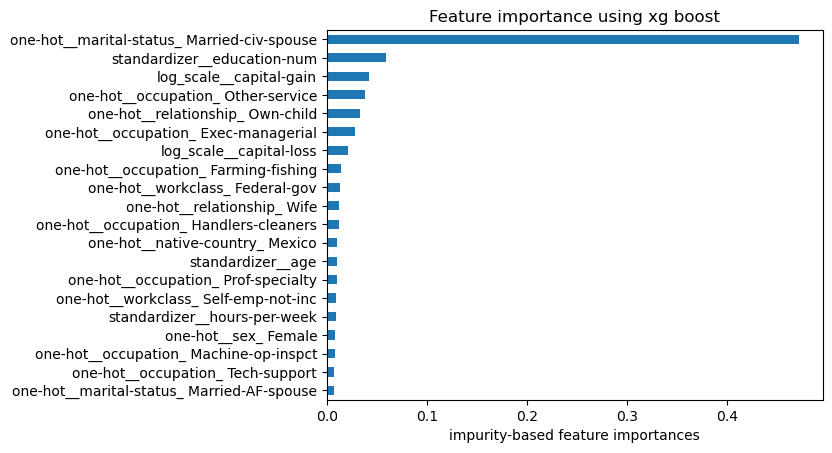

In [173]:
# for xgboost model

# get importance and feature name
importance = pd.Series(gridsearch_xgb.best_estimator_[1].feature_importances_, index=pipeline_X.get_feature_names_out())

# plot
f, ax = plt.subplots()
importance.sort_values(ascending=False).head(20).sort_values().plot.barh(ax=ax)
ax.set_title('Feature importance using xg boost')
ax.set_xlabel('impurity-based feature importances')

# References:
- [In Depth: Parameter tuning for Gradient Boosting](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae)